In [2]:
library(recipes)

library(glmnet)
library(caret)

library(vip)

In [3]:
ames <- ames <- AmesHousing::make_ames()

In [4]:
index <- sample(1:dim(ames)[1], 0.7*dim(ames)[1])
ames_train <- ames[index,]
ames_test <- ames[-index,]
dim(ames_train) ; dim(ames_test)

[1] 2051   81

[1] 879  81

## 정규화
- OLS 회귀의 목적은 관찰된 응답 값과 예측된 응답 값 사이의 오차 제곱합(SSE)을 최소화하는 초평면을 찾는것




#### OLS 회귀의 주요 가정
1. 선형 관계
2. 변수 수(p) < 관측값 수(n) 
3. 다중공선성이 없거나 거의 없음.
4. 잔차의 정규성, 등분산성

## 릿지 규제
-  모델의 모든 변수를 유지하면서도, 덜 영향력 있는 변수가 생성할 수 있는 노이즈를 줄여야 한다고 생각하는 경우
- lambda가 0인경우 OLS와 동일
<img src = "https://bradleyboehmke.github.io/HOML/06-regularized-regression_files/figure-html/ridge-coef-example-1.png">

### 라쏘 규제
- 데이터 세트에 많은 변수가 있는 경우 라쏘를 사용하여 가장 크고 일관된 신호를 가진 변수를 식별하고 추출
- 라쏘 패널티로 전환하면 모델이 향상될 뿐만 아니라 자동화된 기능 선택도 수행

<img src = "https://bradleyboehmke.github.io/HOML/06-regularized-regression_files/figure-html/lasso-coef-example-1.png">

### 엘라스틱 넷
- 릿지와 라쏘를 결합
- 라쏘 모델이 기능 선택을 수행하지만 두 개의 강력한 상관 관계가 0으로 푸시되면 하나는 완전히 0으로 푸시되고 다른 하나는 모델에 남아 있을 수 있다. 
- 하나의 변수가 포함되고 제외되는 과정이 그다지 체계적이지 못하다. 
- 대조적으로, 릿지 모델은 상관된 기능을 함께 체계적으로 처리하는 데 조금 더 효과적 - 따라서, Elastic Net Penalty의 장점은 라쏘 패널티의 특징 선택 특성과 함께 릿지 패널티를 통해 효과적인 정규화를 가능하게 한다는 점이다.

<img src = "https://bradleyboehmke.github.io/HOML/06-regularized-regression_files/figure-html/elastic-net-coef-example-1.png">

### 구현

### ```model.matrix()``` 
- 더미 인코딩

In [5]:
library(Matrix)

In [19]:
X <- model.matrix(Sale_Price ~ ., ames_train)[, -1]
head(X)

,MS_SubClassOne_Story_1945_and_Older,MS_SubClassOne_Story_with_Finished_Attic_All_Ages,MS_SubClassOne_and_Half_Story_Unfinished_All_Ages,MS_SubClassOne_and_Half_Story_Finished_All_Ages,MS_SubClassTwo_Story_1946_and_Newer,MS_SubClassTwo_Story_1945_and_Older,MS_SubClassTwo_and_Half_Story_All_Ages,MS_SubClassSplit_or_Multilevel,MS_SubClassSplit_Foyer,MS_SubClassDuplex_All_Styles_and_Ages,...,Sale_TypeOth,Sale_TypeVWD,Sale_TypeWD,Sale_ConditionAdjLand,Sale_ConditionAlloca,Sale_ConditionFamily,Sale_ConditionNormal,Sale_ConditionPartial,Longitude,Latitude
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,-93.68514,42.02969
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-93.64178,42.05418
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,-93.60711,42.03473
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,-93.65607,42.05860
5,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,-93.60317,41.99691
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,-93.64150,42.05125


In [20]:
Y <- log(ames_train$Sale_Price)

### ``` glmnet() ```
- alpha = 0 : 릿지
- alpha = 1 : 라쏘
- 0 < alpha < 1 : 엘라스틱 넷

#### ***glmnet은 자동으로 변수를 표준화*** (표준화 안하려면 standardize = F)

#### glmnet은 lambda값의 범위를 100까지(수정 필요X)

In [32]:
ridge <- glmnet(
  x = X,
  y = Y,
  alpha = 0
)

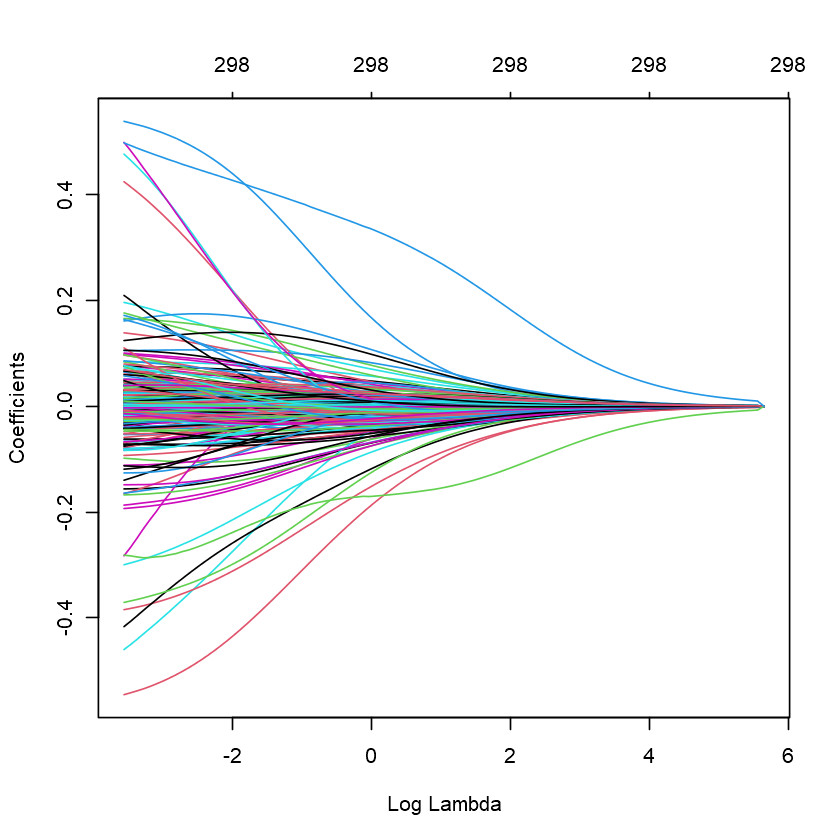

In [33]:
plot(ridge, xvar = "lambda")

In [36]:
ridge$lambda %>% head

[1] 284.3860 259.1219 236.1022 215.1276 196.0162 178.6027

- lambda값이 0일때의 계수

In [45]:
coef(ridge)[c("Latitude", "Overall_QualVery_Excellent"), 1]  

Latitude Overall_QualVery_Excellent 
              6.609551e-36               9.795266e-37

* lambda값이 100일떄의 계수

In [46]:
coef(ridge)[c("Latitude", "Overall_QualVery_Excellent"), 100]

Latitude Overall_QualVery_Excellent 
                 0.4983001                  0.1053826

### 튜닝
### ```cv.glmnet()```
```
cv.glmnet(
  x,
  y,
  weights = NULL,
  offset = NULL,
  lambda = NULL,
  type.measure = c("default", "mse", "deviance", "class", "auc", "mae", "C"),
  nfolds = 10,
  foldid = NULL,
  alignment = c("lambda", "fraction"),
  grouped = TRUE,
  keep = FALSE,
  parallel = FALSE,
  gamma = c(0, 0.25, 0.5, 0.75, 1),
  relax = FALSE,
  trace.it = 0,
  ...
)```

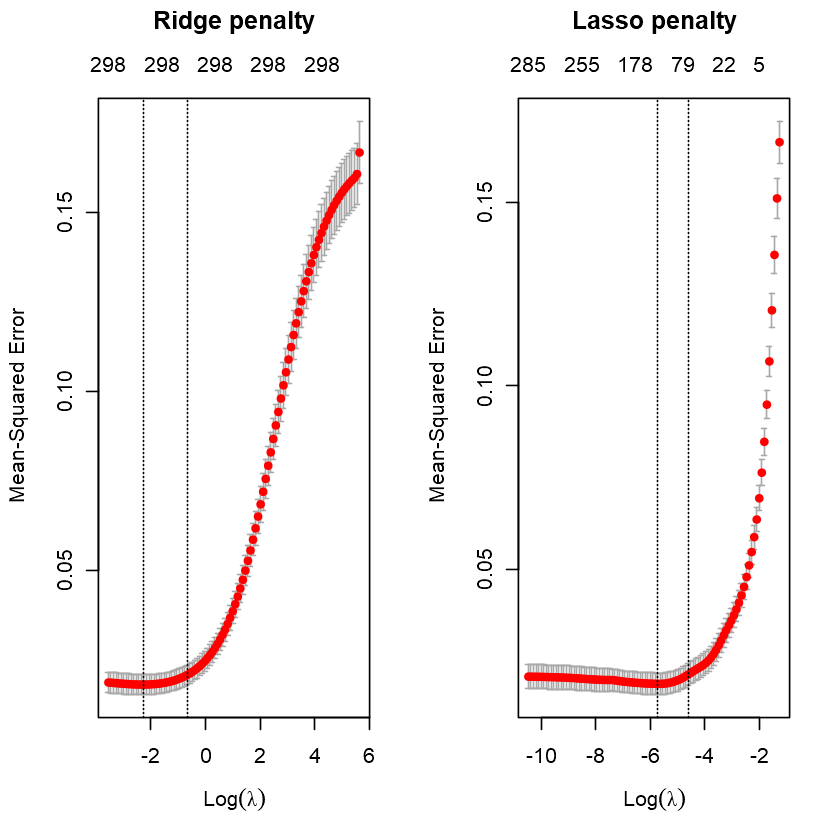

In [50]:
ridge <- cv.glmnet(
  x = X,
  y = Y,
  nfolds = 10,
  alpha = 0
)

lasso <- cv.glmnet(
  x = X,
  y = Y,
  nfolds = 10,
  alpha = 1
)

par(mfrow = c(1, 2))
plot(ridge, main = "Ridge penalty\n\n")
plot(lasso, main = "Lasso penalty\n\n")

- 수직점선은 최소 MSE의 1 표준 오차 이내의 MSE
- 상단의 숫자는 모델의 0이 아닌 변수 수
- 릿지회귀는 모든 변수를 정확히 0으로 만들지 않으므로, 모든 변수가 유지, 라쏘회귀는 변수의 수가 감소


#### 릿지회귀의 최소 MSE와 lambda값

In [66]:
min(ridge$cvm)
ridge$lambda.min

[1] 0.01796508

[1] 0.104608

#### 릿지회귀의 최소 MSE에서 1-SE 떨어진 MSE와 labda값

In [70]:
ridge$cvm[ridge$lambda == ridge$lambda.1se]
ridge$lambda.1se

[1] 0.02062858

[1] 0.5086669

#### 라쏘회귀의 최소 MSE와 lambda값, 0이아닌 변수의 수

In [71]:
min(lasso$cvm) 
lasso$lambda.min
lasso$nzero[lasso$lambda == lasso$lambda.min] 

[1] 0.01869186

[1] 0.003269748

s48 
120

#### 라쏘회귀의 최소 MSE에서 1-SE 떨어진 MSE와 labda값, 0이아닌 변수의 수

In [72]:
lasso$cvm[lasso$lambda == lasso$lambda.1se]
lasso$lambda.1se
lasso$nzero[lasso$lambda == lasso$lambda.1se]

[1] 0.02124517

[1] 0.009985337

s36 
 73

- 릿지회귀가 298개의 모든 변수를 사용하고 있는 반면 라쏘회귀는 변수를 120으로 줄이는 동안 유사한 MSE를 얻을 수 있음을 보여줌
- 라쏘회귀는 73개의 변수만 사용하여 거의 동일한 정확도를 얻음

In [73]:
ridge_min <- glmnet(
  x = X,
  y = Y,
  alpha = 0
)

lasso_min <- glmnet(
  x = X,
  y = Y,
  alpha = 1
)

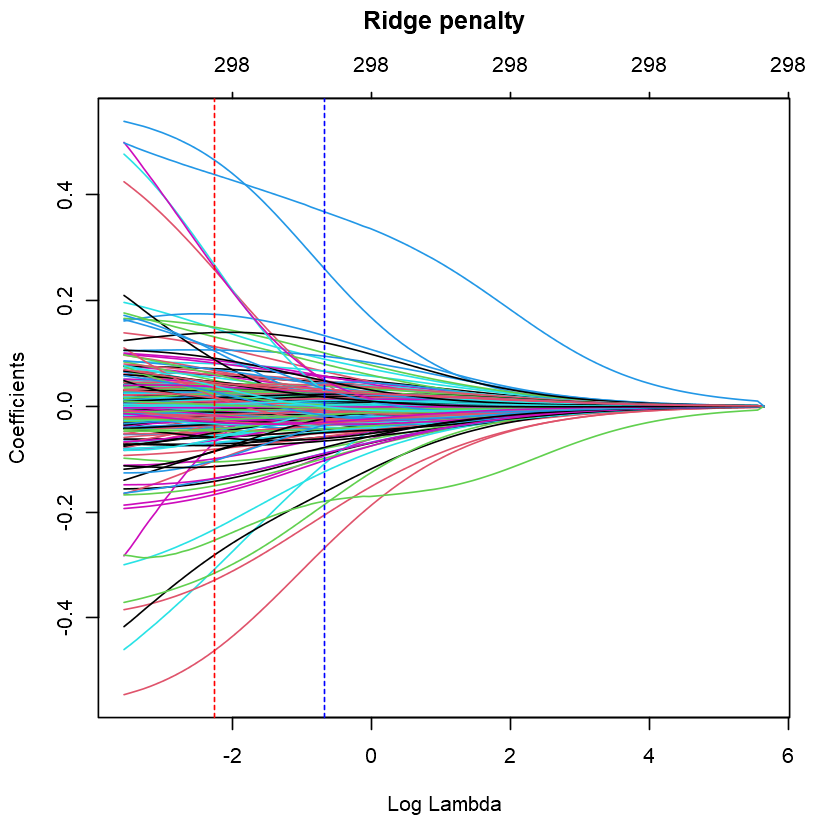

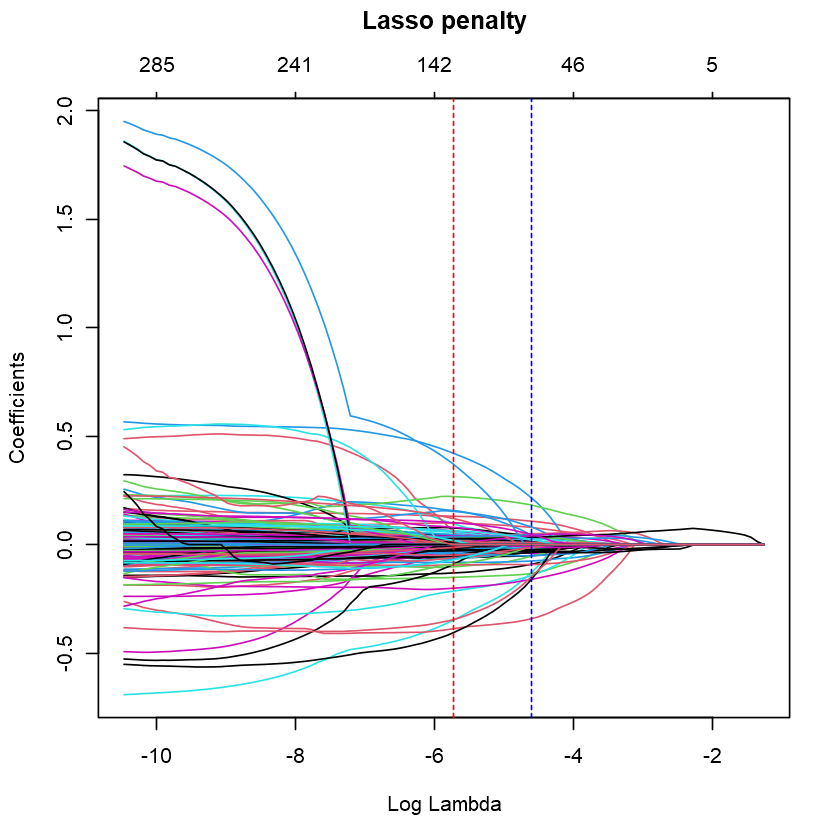

In [77]:
plot(ridge_min, xvar = "lambda", main = "Ridge penalty\n\n")
abline(v = log(ridge$lambda.min), col = "red", lty = "dashed")
abline(v = log(ridge$lambda.1se), col = "blue", lty = "dashed")

plot(lasso_min, xvar = "lambda", main = "Lasso penalty\n\n")
abline(v = log(lasso$lambda.min), col = "red", lty = "dashed")
abline(v = log(lasso$lambda.1se), col = "blue", lty = "dashed")

In [81]:
elastic_1 <- glmnet(
  x = X,
  y = Y,
  alpha = 0.25
)

elastic_2 <- glmnet(
  x = X,
  y = Y,
  alpha = 0.75
)

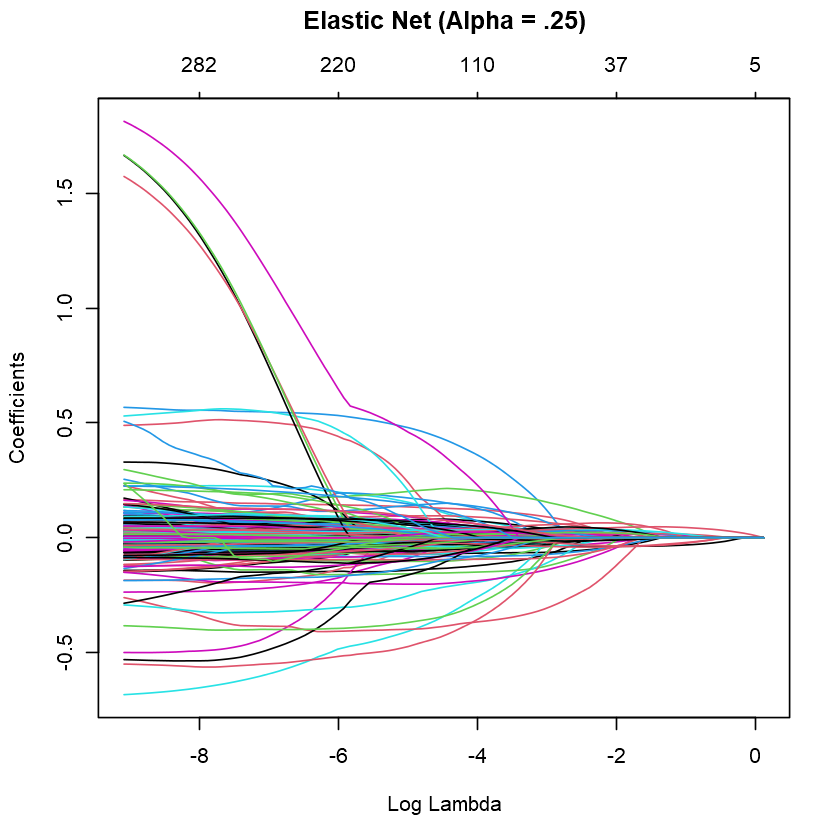

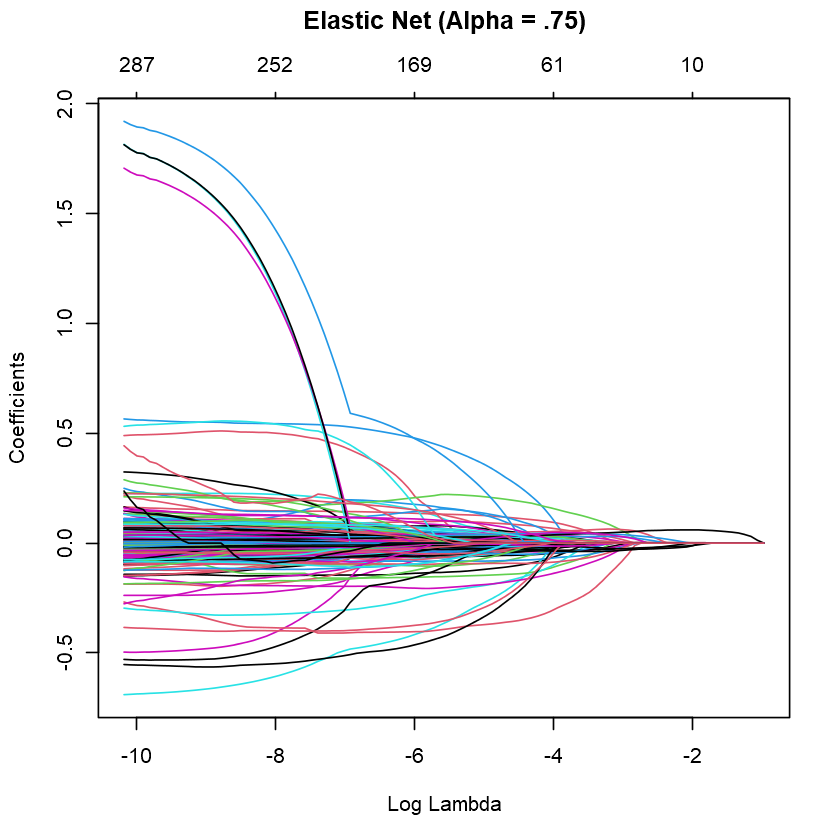

In [83]:
plot(elastic_1, xvar = "lambda", main = "Elastic Net (Alpha = .25)\n\n")
plot(elastic_2, xvar = "lambda", main = "Elastic Net (Alpha = .75)\n\n")

### 그리드 서치

#### ```tuneLength = 0``` : 0 ~ 1까지 lambda값을 10개의 구간으로

In [84]:
set.seed(123)

cv_glmnet <- train(
  x = X,
  y = Y,
  method = "glmnet",
  preProc = c("zv", "center", "scale"),
  trControl = trainControl(method = "cv", number = 10),
  tuneLength = 10
)

In [85]:
cv_glmnet$bestTune

,alpha,lambda
,<dbl>,<dbl>
7,0.1,0.01997067


In [86]:
cv_glmnet$results %>%
  filter(alpha == cv_glmnet$bestTune$alpha, lambda == cv_glmnet$bestTune$lambda)

alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1,0.01997067,0.1301868,0.9003958,0.08087676,0.02478734,0.03415984,0.005498594


Warning message:
"The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 10. Consider
specifying shapes manually if you must have them."
Warning message:
"Removed 40 rows containing missing values (geom_point)."


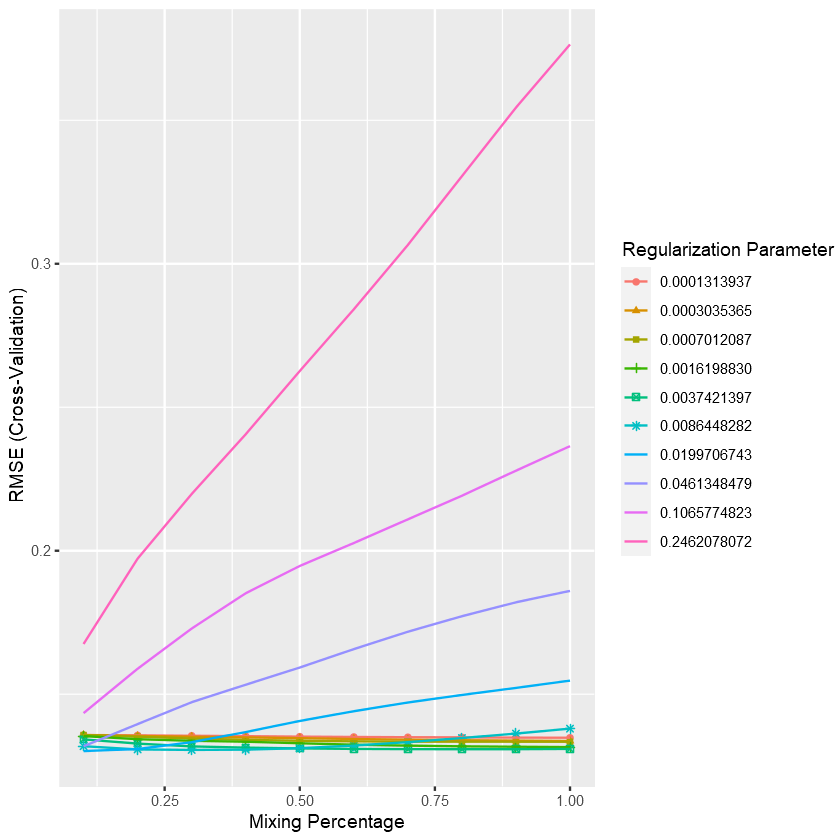

In [87]:
ggplot(cv_glmnet)

In [88]:
pred <- predict(cv_glmnet, X)
RMSE(exp(pred), exp(Y))

[1] 20597.1

### 변수 중요도

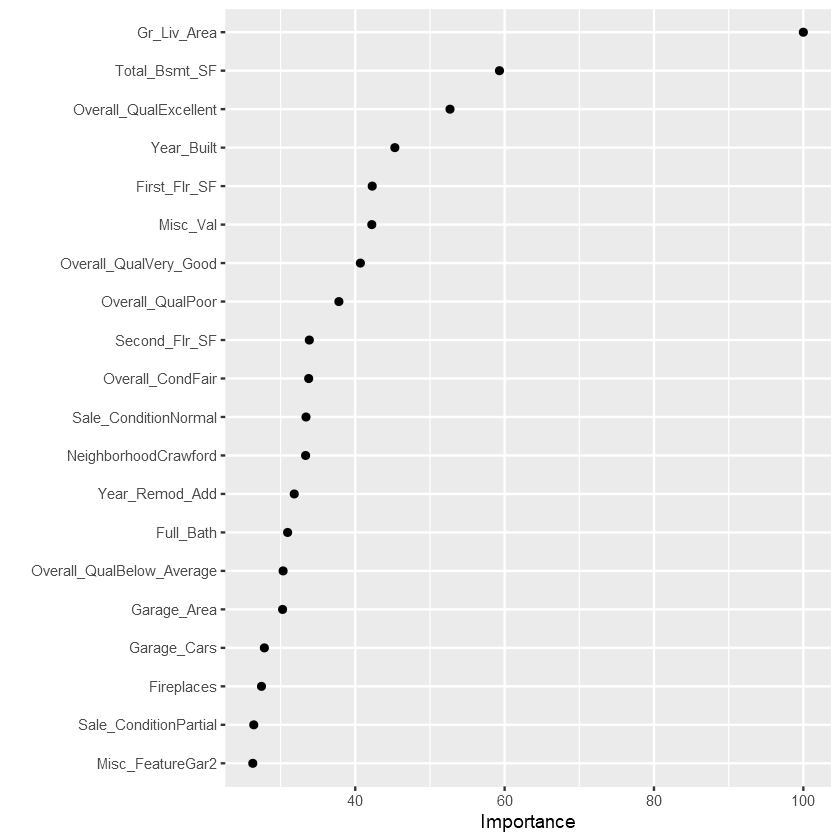

In [90]:
vip(cv_glmnet, num_features = 20, geom = "point")

### 정규화 로지스틱 회귀

In [91]:
attrition <- read.csv("C:/Users/apf_temp_admin/Documents/Hands on Machine Learning/WA_Fn-UseC_-HR-Employee-Attrition.csv",
                     stringsAsFactors = T)

In [92]:
colnames(attrition)[1] <- "Age"

In [94]:
set.seed(123)
churn_split <- rsample::initial_split(attrition, prop = 0.7, strata = "Attrition")
churn_train <- rsample::training(churn_split)
churn_test <- rsample::testing(churn_split)

In [95]:
set.seed(123)
glm_mod <- train(
  Attrition ~ ., 
  data = churn_train[, -c(9, 22, 27)], 
  method = "glm",
  family = "binomial",
  preProc = c("zv", "center", "scale"),
  trControl = trainControl(method = "cv", number = 10)
)

In [101]:
set.seed(123)
penalized_mod <- train(
  Attrition ~ ., 
  data = churn_train[, -c(9, 22, 27)], 
  method = "glmnet",
  family = "binomial",
  preProc = c("zv", "center", "scale"),
  trControl = trainControl(method = "cv", number = 10),
  tuneLength = 10 
  )

In [98]:
summary(resamples(list(
  logistic_model = glm_mod, 
  penalized_model = penalized_mod
  )))


Call:
summary.resamples(object = resamples(list(logistic_model =
 glm_mod, penalized_model = penalized_mod)))

Models: logistic_model, penalized_model 
Number of resamples: 10 

Accuracy 
                     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.
logistic_model  0.8349515 0.8564630 0.8743932 0.8735175 0.8832096 0.9126214
penalized_model 0.8446602 0.8696267 0.8829240 0.8862244 0.9095517 0.9126214
                NA's
logistic_model     0
penalized_model    0

Kappa 
                     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.
logistic_model  0.2791272 0.4074426 0.4441872 0.4574284 0.5008789 0.6183615
penalized_model 0.3011026 0.3802759 0.4671794 0.4647929 0.5669838 0.5974815
                NA's
logistic_model     0
penalized_model    0
